In [19]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import mean_squared_error

#https://qiita.com/okotaku/items/8d682a11d8f2370684c9
import os
import random
import tensorflow as tf
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
seed_everything(42)

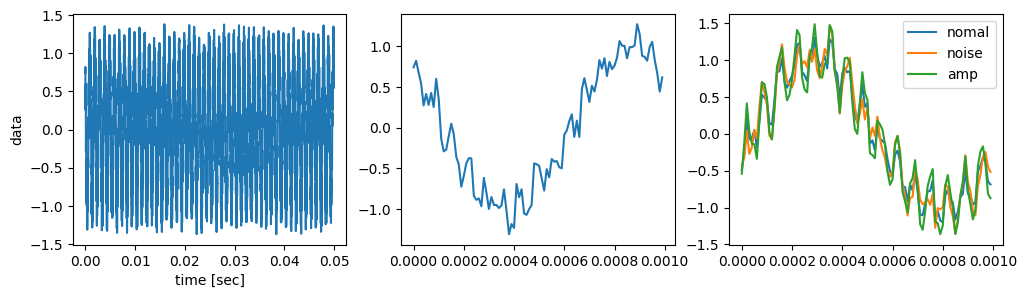

In [20]:
#変数をいろいろ設定
sampling_frequency = 100000 #サンプリング周波数
sampling_length = 5000 #サンプリング点数
data_train_num = 500 #学習用生成データ数
data_test_num = 50 #テスト用生成データ数

freq_nomal_low = 1000 #データの主周波数
freq_nomal_high = 15000 #正常データ重畳周波数
freq_abnomal = 11000 #異常データ重畳周波数
freq_shift_1 = 14000 
freq_shift_2 = 13000 

amp_nomal_low = 1.0 #正常データ振幅レベル
amp_nomal_high = 0.2 #正常データ振幅レベル
amp_white_noise = 0.2 #正常データ振幅レベル
amp_abnomal_noise_1 = 0.1 #異常データ振幅レベル1
amp_abnomal_noise_2 = 0.2 #異常データ振幅レベル2
amp_abnomal_level_1 = 0.5 #異常データ振幅レベル1
amp_abnomal_level_2 = 1.0 #異常データ振幅レベル2

#データ用配列を定義
data_raw_train=[] #学習用正常データ
data_raw_test={}
data_raw_test['nomal']=[] #テスト用正常データ
data_raw_test['noise_1']=[] #高周波ノイズ　レベル1
data_raw_test['noise_2']=[] #高周波ノイズ　レベル2
data_raw_test['amp_1']=[] #振幅増加　レベル1
data_raw_test['amp_2']=[] #振幅増加　レベル2
data_raw_test['noise_amp_1']=[] #高周波ノイズ + 振幅増加　レベル1
data_raw_test['noise_amp_2']=[] #高周波ノイズ + 振幅増加　レベル2
data_raw_test['high_shift_1']=[] #高周波ノイズ + 振幅増加　レベル1
data_raw_test['high_shift_2']=[] #高周波ノイズ + 振幅増加　レベル2

#時間データ生成
timeline = np.arange(sampling_length)/sampling_frequency

def func_make_sin(frequency):
    phase = 2 * np.pi * np.random.rand()
    return np.sin(2 * np.pi * frequency * timeline + phase)

#学習用データ生成
for i in range(data_train_num):
    nomal_low = func_make_sin(freq_nomal_low) * amp_nomal_low
    nomal_high = func_make_sin(freq_nomal_high) * amp_nomal_high
    white_noise = (np.random.rand(len(timeline))-0.5) * 2 * amp_white_noise
    data_raw_train.append(nomal_low + nomal_high + white_noise) 

#テスト用データ生成
for i in range(data_test_num):
    nomal_low = func_make_sin(freq_nomal_low) * amp_nomal_low
    nomal_high = func_make_sin(freq_nomal_high) * amp_nomal_high
    white_noise = (np.random.rand(len(timeline))-0.5) * 2 * amp_white_noise
    nomal = nomal_low + nomal_high + white_noise
    abnomal_amp_1 = nomal_high * amp_abnomal_level_1
    abnomal_amp_2 = nomal_high * amp_abnomal_level_2
    abnomal_noise_1 = func_make_sin(freq_abnomal) * amp_abnomal_noise_1
    abnomal_noise_2 = func_make_sin(freq_abnomal) * amp_abnomal_noise_2
    abnomal_shift_1 = nomal_low + func_make_sin(freq_shift_1) * amp_nomal_high + white_noise
    abnomal_shift_2 = nomal_low + func_make_sin(freq_shift_2) * amp_nomal_high + white_noise
    
    data_raw_test['nomal'].append(nomal) 
    data_raw_test['noise_1'].append( nomal + abnomal_noise_1 ) 
    data_raw_test['noise_2'].append( nomal + abnomal_noise_2 ) 
    data_raw_test['amp_1'].append( nomal + abnomal_amp_1 ) 
    data_raw_test['amp_2'].append( nomal + abnomal_amp_2 ) 
    data_raw_test['noise_amp_1'].append( nomal + abnomal_amp_1 + abnomal_noise_1 ) 
    data_raw_test['noise_amp_2'].append( nomal + abnomal_amp_2 + abnomal_noise_2 ) 
    data_raw_test['high_shift_1'].append(abnomal_shift_1) 
    data_raw_test['high_shift_2'].append(abnomal_shift_2) 

#生成データの確認
plt.style.use(['default'])
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(timeline, data_raw_train[0])
plt.xlabel("time [sec]")
plt.ylabel("data")
plt.subplot(1,3,2)
plt.plot(timeline[:100], data_raw_train[0][:100])
plt.subplot(1,3,3)
plt.plot(timeline[:100], data_raw_test['nomal'][0][:100],label='nomal')
plt.plot(timeline[:100], data_raw_test['noise_2'][0][:100],label='noise')
plt.plot(timeline[:100], data_raw_test['amp_2'][0][:100],label='amp')
plt.legend()
plt.show()

(500, 5000)
(500, 5000, 1)
(500, 5000, 1)


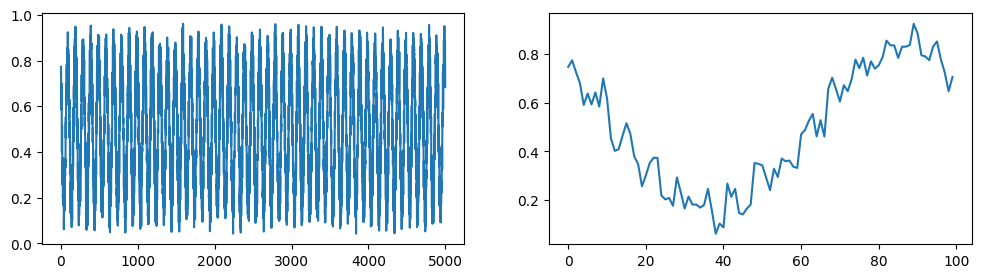

In [21]:
#入力用データに変換
DATA_MAX=1.5
DATA_MIN=-1.5
def func_make_input(source):
    input_train=np.array(source)
    input_train=(input_train-DATA_MIN)/(DATA_MAX-DATA_MIN)
    input_train=np.clip(input_train,0.0,1.0)
    print(input_train.shape)
    return np.reshape(input_train, (input_train.shape[0], input_train.shape[1], 1))
train_X = func_make_input(data_raw_train)
train_Y = train_X

print(train_X.shape)
print(train_Y.shape)

plt.style.use(['default'])
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.plot(train_X[0])
plt.subplot(1,2,2)
plt.plot(train_X[0][:100])
plt.show()

In [22]:
model = keras.models.Sequential()
# model.add(keras.layers.LSTM(300, activation='relu', return_sequences=True, input_shape=(LEN_INPUT, 1)))
# model.add(keras.layers.LSTM(300, activation='relu'))
# model.add(keras.layers.Dense(25, activation='softmax'))
# model.compile(loss='mse', optimizer='adam')
model.add(keras.layers.Conv1D(10, 10, padding='same', input_shape=(train_X.shape[1], 1), activation='relu'))
model.add(keras.layers.MaxPooling1D(2, padding='same'))
model.add(keras.layers.Conv1D(10, 10, padding='same', activation='relu'))
model.add(keras.layers.MaxPooling1D(2, padding='same'))
model.add(keras.layers.Conv1D(10, 10, padding='same', activation='relu'))
model.add(keras.layers.UpSampling1D(2))
model.add(keras.layers.Conv1D(10, 10, padding='same', activation='relu'))
model.add(keras.layers.UpSampling1D(2))
model.add(keras.layers.Conv1D(1, 10, padding='same', activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')
print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 5000, 10)          110       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2500, 10)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2500, 10)          1010      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1250, 10)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 1250, 10)          1010      
_________________________________________________________________
up_sampling1d_6 (UpSampling1 (None, 2500, 10)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 2500, 10)         

In [23]:
# EPOCHS=30
# #学習
# history = model.fit(train_X, train_Y, validation_split=0.1, epochs=EPOCHS)
# model.save('test.h5')
# #損失プロット
# plt.plot(range(EPOCHS), history.history['loss'], label='loss')
# plt.plot(range(EPOCHS), history.history['val_loss'], label='val_loss')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend() 
# plt.show()

model = keras.models.load_model('test.h5')

(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)


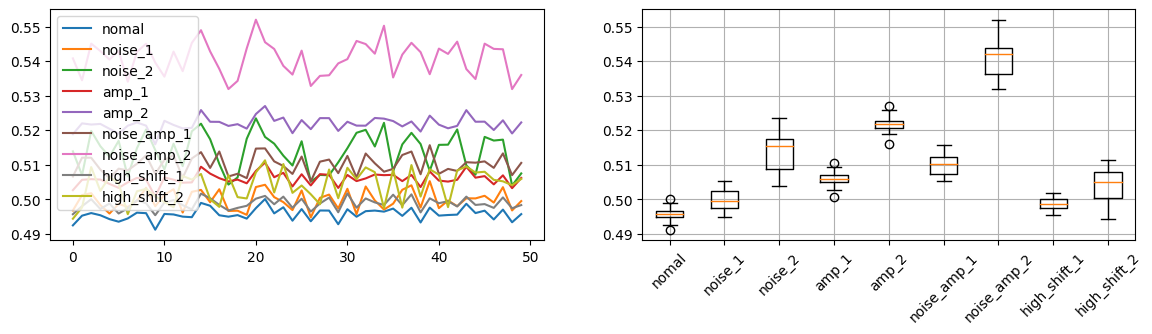

(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)
(50, 5000)


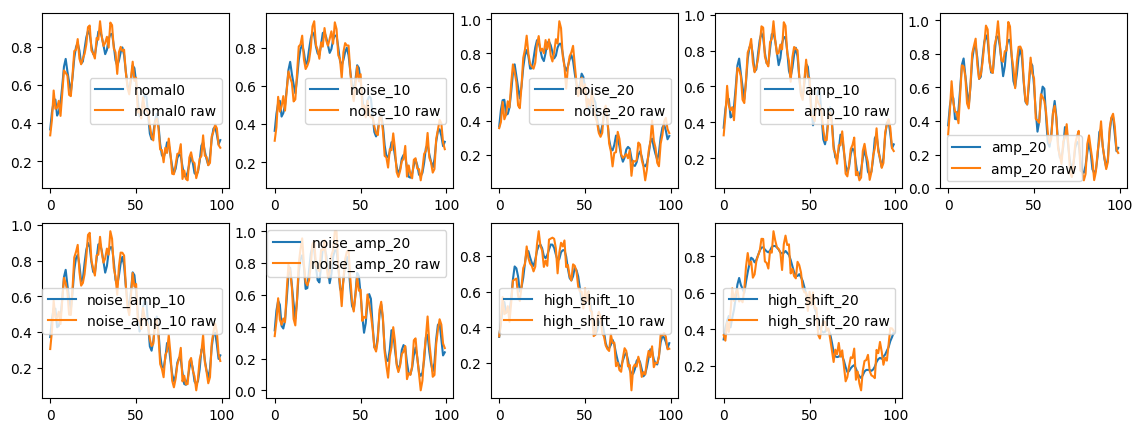

In [31]:

dic_mse={}
dic_output={}
for key,value in data_raw_test.items():
    output = model.predict(func_make_input(value))
    dic_output[key]=output
    list_mse=[]
    for i in range(output.shape[0]):
        list_mse.append( mean_squared_error(value[i], output[i]))
    dic_mse[key]=list_mse

plt.figure(figsize=(14,3))
plt.subplot(121)
for key,value in dic_mse.items():
    plt.plot(value,label=key)
plt.legend() 

plt.subplot(122)
plt.boxplot(dic_mse.values(),labels=dic_mse.keys())
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


plt.style.use(['default'])
plt.figure(figsize=(14,5))

for k,(key,value) in enumerate(dic_output.items(),1):
    plt.subplot(2,5,k)
    for i in range(1):
        plt.plot(value[i,:100],label=key+str(i))
        input=func_make_input(data_raw_test[key])
        plt.plot(input[i][:100],label=key+str(i)+' raw')
    plt.legend()
plt.show()

